In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import shutil
import tensorflow 
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from matplotlib import image
from keras.optimizers import SGD

In [2]:
# Define constants

# Define number of classes to use (this is a way to subset the data)
CLASS_NUM = 3

BATCH_SIZE = 32

In [3]:
#data preprocessing 
# Store paths to base, train set and subset dirs
base_dir = "/kaggle/input/imagenet-object-localization-challenge"
train_dir = base_dir + "/ILSVRC/Data/CLS-LOC/train"
subset_dir = "/kaggle/working/data"

if not os.path.exists(subset_dir):
    os.mkdir(subset_dir)
    print(subset_dir, "created!")
else:
    print(subset_dir, "already exists!")
    
# Select only first n class dirs
class_dirs = os.listdir(train_dir)[:CLASS_NUM]

# Copy class dir from train set to working dir
for class_dir in class_dirs:
    # Define current source and destination paths
    source_dir = train_dir + "/" + class_dir
    destination_dir = subset_dir + "/" + class_dir
    
    # If new class, copy to working dir
    if not os.path.exists(destination_dir):
        shutil.copytree(source_dir, destination_dir)
        print(class_dir, "succesfully copied!")
    # If it exists, don't copy again
    else:
        print(class_dir, "doesn't need copying!")

/kaggle/working/data created!
n01531178 succesfully copied!
n02412080 succesfully copied!
n02098413 succesfully copied!


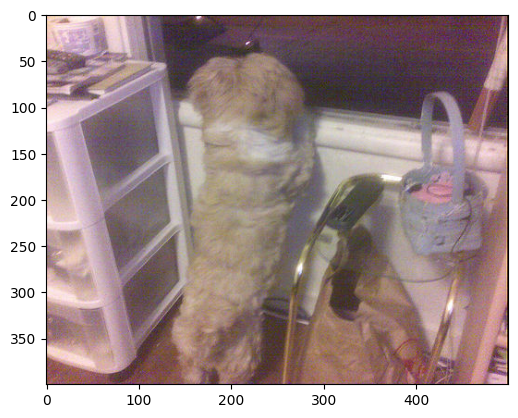

In [4]:
# Read in image
image = image.imread(subset_dir + "/n02098413/n02098413_720.JPEG")
# Show image
plt.imshow(image)

In [5]:
# Import train set as a Dataset object
# (this object type can be used as input to the model)
raw_train_set = tf.keras.utils.image_dataset_from_directory(subset_dir, image_size=(224, 224))


Found 3900 files belonging to 3 classes.


model building 

In [6]:
# Normalise images to [0-1] scale
train_set = raw_train_set.map(lambda x, y: (x / 255, y))
# Separate images and labels
images, labels = next(iter(train_set))

# Prepare data for training
X_train = images
y_train = pd.get_dummies(labels)

print('done')

done


Train a CNN (11 layers at first). Specifically: 
train using minibatch gradient descent (size 256), backpropagation w momentum. 
the learning rate (start at 10-2) decreased 3 times, and the learning stopped after 370K iterations (74 epochs).
L2 regularization, penalty multiplier set to 5 · 10−4 
Dropout regularization 
Weight initialization (paragraph 3.1: Training)  is random for shallow network and then weights are transferred to deeper model (LR didn’t change for transferred theta values once transferred to deeper model). 
Training image size: S =  384 and S = 256. Isotropical rescale: It means apply the same scaling factor along width and height, so the image doesn't become distorted along one axis.


docs for: 

**tf.keras.layers.Dense(**
    units,
    activation=None,
    use_bias=True,
    kernel_initializer='glorot_uniform',
    bias_initializer='zeros',
    kernel_regularizer=None,
    bias_regularizer=None,
    activity_regularizer=None,
    kernel_constraint=None,
    bias_constraint=None,
    ** kwargs
)

and 

**keras.layers.Conv2D** ( filters,
    kernel_size,
    strides=(1, 1),
    padding='valid',
    data_format=None,
    dilation_rate=(1, 1),
    groups=1,
    activation=None,
    use_bias=True,
    kernel_initializer='glorot_uniform',
    bias_initializer='zeros',
    kernel_regularizer=None,
    bias_regularizer=None,
    activity_regularizer=None,
    kernel_constraint=None,
    bias_constraint=None,
    ** kwargs

and 

**tf.keras.layers.MaxPooling2D**(
    pool_size=(2, 2),
    strides=None,
    padding='valid',
    data_format=None,
    **kwargs
)

In [7]:
#create convolutional base

#refer to table 1 for architecture 
model = tf.keras.Sequential(name='CNN_11_layer_trial')

#useful comments for understanding layout, once we're all aligned delete: 

#Spatial pooling is carried out by five max-pooling layers, which follow some of the conv. layers (not all the conv. layers are followed
#by max-pooling). 
#Max-pooling is performed over a 2 × 2 pixel window, with stride 2.
#for conv layers: increasing filters by *2 for each conv layer, starting at 64 until 512
#input shape mandatory in first layer: image shape and 3, stands for RGB


model.add(layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation='relu', input_shape=(224, 224, 3))) #1
model.add(layers.MaxPooling2D((2, 2), strides = 2))
model.add(layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same', activation='relu')) #2
model.add(layers.MaxPooling2D((2, 2), strides = 2)) 
model.add(layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same', activation='relu')) #3
model.add(layers.Conv2D(512, (3, 3),  strides=(1, 1), padding='same', activation='relu')) #4
model.add(layers.MaxPooling2D((2, 2), strides = 2))
model.add(layers.Conv2D(512, (3, 3),  strides=(1, 1), padding='same', activation='relu')) #5
model.add(layers.Conv2D(512, (3, 3),  strides=(1, 1), padding='same', activation='relu')) #6
model.add(layers.Conv2D(512, (3, 3),  strides=(1, 1), padding='same', activation='relu')) #7
model.add(layers.Conv2D(512, (3, 3),  strides=(1, 1), padding='same', activation='relu')) #8
model.add(layers.MaxPooling2D((2, 2), strides = 2)) #final maxpool before fully connected layers 
#5th and last maxpool layer: 
model.add(layers.MaxPooling2D((2, 2), strides = 2))
#9,10,11 are fully conntected layers
#9
model.add(layers.Flatten()) #dense layers expect flat vectors, not tensors
model.add(layers.Dense(4096)) #4096 units
#10
model.add(layers.Dense(4096)) #4096 units
#11
model.add(layers.Dense(3)) #1000 units, 1000- way ILSVRC classification; here 3 for subset
#softmax before output
model.add(tf.keras.layers.Softmax(axis=-1))   #apply softmax to last dimension of input data

In [8]:
model.summary()

Model: "CNN_11_layer_trial"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 256)       295168    
                                                                 
 conv2d_3 (Conv2D)           (None, 56, 56, 512)

In [9]:
#train model 

from keras.optimizers import SGD

# Define the optimizer separately so we have better hyperparams control 
sgd = SGD(lr=0.01, momentum=0.9) #TODO: change learning rate 

#in 11 layer, paper initializes weights randomly
weights = [np.random.rand(*w.shape) for w in model.get_weights()]
model.set_weights(weights)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=sgd)

model.compile(
    optimizer=sgd,  # Optimizer
    # Loss function to minimize
    loss='categorical_crossentropy', #multinomial logistic regression
    # List of metrics to monitor
    metrics=['accuracy']
)


print("Fit model on training data")
history = model.fit(
    X_train, #X_train = images
    y_train, #pd.get_dummies(labels)
    batch_size=2, 
    #validation_split=0.15, #we might not need to do this? as this is just a test 
    epochs=35,
)

Fit model on training data
Epoch 1/35
16/16 [==============================] - 52s 3s/step - loss: nan - accuracy: 0.3750
Epoch 2/35
16/16 [==============================] - 48s 3s/step - loss: nan - accuracy: 0.3438
Epoch 3/35
16/16 [==============================] - 52s 3s/step - loss: nan - accuracy: 0.3438
Epoch 4/35
16/16 [==============================] - 51s 3s/step - loss: nan - accuracy: 0.3438
Epoch 5/35
16/16 [==============================] - 49s 3s/step - loss: nan - accuracy: 0.3438
Epoch 6/35
16/16 [==============================] - 49s 3s/step - loss: nan - accuracy: 0.3438
Epoch 7/35
16/16 [==============================] - 49s 3s/step - loss: nan - accuracy: 0.3438
Epoch 8/35
16/16 [==============================] - 48s 3s/step - loss: nan - accuracy: 0.3438
Epoch 9/35
16/16 [==============================] - 48s 3s/step - loss: nan - accuracy: 0.3438
Epoch 10/35
16/16 [==============================] - 48s 3s/step - loss: nan - accuracy: 0.3438
Epoch 11/35
16/16 [===

In [10]:
#The returned history object holds a record of the loss values and metric values during training:
history.history

{'loss': [nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan],
 'accuracy': [0.375,
  0.34375,
  0.34375,
  0.34375,
  0.34375,
  0.34375,
  0.34375,
  0.34375,
  0.34375,
  0.34375,
  0.34375,
  0.34375,
  0.34375,
  0.34375,
  0.34375,
  0.34375,
  0.34375,
  0.34375,
  0.34375,
  0.34375,
  0.34375,
  0.34375,
  0.34375,
  0.34375,
  0.34375,
  0.34375,
  0.34375,
  0.34375,
  0.34375,
  0.34375,
  0.34375,
  0.34375,
  0.34375,
  0.34375,
  0.34375]}

In [11]:
#TODO: subtract the mean RGB value, computed on the training set, from each pixel
#TODO: check if need to zero gradient after update or done under hood in Tensor Flow